# Analyze the Null Distribution of Control Alleles

In [1]:
# imports
import os
import glob
import operator
import polars as pl
import pandas as pd
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from functools import reduce
import sys
sys.path.append("../..")
from img_utils import *
sys.path.append("cell_img_visualization")
from display_img import *

letter_dict_rev = {v: k for k, v in letter_dict.items()}
channel_dict_rev = {v: k for k, v in channel_dict.items()}
channel_list = list(channel_dict_rev.values())[:-3]

%matplotlib inline
## Disable truncation globally
# pl.Config.set_tbl_rows(20)  # Show all rows
# pl.Config.set_tbl_cols(40)  # Show all columns

## define control types
TC = ["EGFP"]
NC = ["RHEB", "MAPK9", "PRKACB", "SLIRP"]
PC = ["ALK", "ALK_Arg1275Gln", "PTK2B"]
cNC = ["Renilla"]
cPC = ["KRAS", "PTK2B", "GHSR", "ABL1", "BRD4", "OPRM1", "RB1", "ADA", "WT PMP22", "LYN", "TNF", 
       "CYP2A6", "CSK", "PAK1", "ALDH2", "CHRM3", "KCNQ2", "ALK T1151M", "PRKCE", "LPAR1", "PLP1"]

TRN_IMBAL_THRES = 3
MIN_CLASS_NUM = 2
AUROC_THRESHOLDS = [0.95, 0.99]
OUT_IMGS_DIR = ""

## 1. Loading the Control Alleles

In [2]:
allele_meta_df = pl.read_csv(IMG_METADATA_FILE, infer_schema_length=10000)
img_well_qc_sum_df = pl.read_csv(IMG_QC_SUM_DF_FILE, infer_schema_length=10000)

with open(IMG_METADATA_DICT_FILE, "rb") as f:
    allele_meta_df_dict = pickle.load(f)

with open(IMG_QC_SUM_DICT_FILE, "rb") as f:
    img_well_qc_sum_dict = pickle.load(f)

In [3]:
class_info_dir = "{}/{}/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells/metrics.csv"
class_info_gfp_adj_dir = "{}/{}/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells/metrics_gfp_adj.csv"

### 1.1 Original

In [4]:
metric_df_dict = {}

for bio_rep, bio_rep_batches in BIO_REP_BATCHES_DICT.items():
    for batch_id in bio_rep_batches:
        metrics_df = pl.read_csv(class_info_dir.format(CLASS_ANALYSES_DIR, batch_id)).with_columns(
            pl.col("Metadata_Feature_Type").alias("Classifier_type")
        )
        metrics_gfp_adj_df = pl.read_csv(class_info_gfp_adj_dir.format(CLASS_ANALYSES_DIR, batch_id))
        metrics_gfp_adj_df = metrics_gfp_adj_df.with_columns(
            pl.lit("GFP_ADJ").alias("Classifier_type")
        )
        metrics_df = pl.concat([metrics_df, metrics_gfp_adj_df])
        batch_id = f"B{batch_id.split('Batch_')[-1]}"
        
        # display(metrics_df)
        print(f"====================================={batch_id} metrics=====================================")
        metrics_df = metrics_df.with_columns(
            pl.when(pl.col("Metadata_Control"))
            .then(pl.lit("1_Ctrl"))
            .otherwise(pl.lit("2_VAR-WT"))
            .alias("Node_Type"),
            # Extract the substring that:
            #  1. Has a digit (\d) immediately before it (anchors the match at a number)
            #  2. Starts with 'A' and then as few characters as needed (A.*?), captured as group 1
            #  3. Stops right before the literal 'T'
            pl.col("Plate").str.extract(r"\d(B.*?)T", 1).alias("Allele_set"),
            pl.col("Full_Classifier_ID").str.split("_").list.last().alias("Batch")
        )
        metrics_df = metrics_df.join(
            img_well_qc_sum_dict[bio_rep].select(pl.col("plate", "well", "channel", "is_bg", "s2n_ratio")),
            left_on=["Plate", "well_0", "Metadata_Feature_Type"],
            right_on=["plate", "well", "channel"]
        ).rename({
            "is_bg": "well_0_is_bg",
            "s2n_ratio": "well_0_s2n"
        })
        metrics_df = metrics_df.join(
            img_well_qc_sum_dict[bio_rep].select(pl.col("plate", "well", "channel", "is_bg", "s2n_ratio")),
            left_on=["Plate", "well_1", "Metadata_Feature_Type"],
            right_on=["plate", "well", "channel"]
        ).rename({
            "is_bg": "well_1_is_bg",
            "s2n_ratio": "well_1_s2n"
        })
    
        """
            Calculating controls
        """
        metrics_ctrl_df = metrics_df.filter(
            (~pl.col("well_0_is_bg")) & (~pl.col("well_1_is_bg")) & \
            (pl.col("Training_imbalance") < TRN_IMBAL_THRES) & (pl.col("Metadata_Control"))
        )
        
        # Filter based on class imbalance
        metrics_ctrl = (
            metrics_ctrl_df
            .select(["Classifier_type", "Batch", "AUROC"])
            .group_by(["Classifier_type", "Batch"])
            .agg([
                pl.col("AUROC").mean().alias("AUROC_mean"),
                pl.col("AUROC").std().alias("AUROC_std")
            ]+[
                pl.col("AUROC").quantile(auroc_thres).alias(f"AUROC_thresh_{auroc_thres*100:.0f}") for auroc_thres in AUROC_THRESHOLDS
            ])
        )
        metric_df_dict[f"{batch_id}_ctrl_df"] = metrics_ctrl_df
        
        for feat in FEAT_SETS:
            print(f"Total number of control classifiers {feat}:", metrics_ctrl_df.filter((pl.col("Classifier_type") == feat)).shape[0])
        
        print("==========================================================================")
        metric_df_dict[f"{batch_id}_met"] = metrics_df
        # Merge with metrics_df and decide whether it passed the threshold
        metrics_df_thres = metrics_df.join(metrics_ctrl, 
                                           left_on=["Metadata_Feature_Type", "Batch"],
                                           right_on=["Classifier_type", "Batch"])
        # print(metrics_df_thres.head())
        metrics_df_thres = metrics_df_thres.with_columns(
            ((pl.col("AUROC") - pl.col("AUROC_mean")) / pl.col("AUROC_std")).alias("AUROC_zscore")
        )
        
        ## Must be at least min_class_num classifiers per batch
        ## Number of classifiers is the same for localization and morph, so just use morph
        classifier_count = (
            metrics_df_thres.filter(
                (~pl.col("Metadata_Control")) & \
                (~pl.col("well_0_is_bg")) & (~pl.col("well_1_is_bg")) & \
                (pl.col("Training_imbalance") < TRN_IMBAL_THRES)
            )
            .group_by(["allele_0", "Allele_set", "Batch", "allele_1"])
            .agg([pl.len().alias("Number_classifiers")])
        )
        classifier_count = classifier_count.pivot(
            index=["allele_0", "allele_1", "Allele_set"],
            on="Batch",
            values="Number_classifiers",
        )
        print(f"Total number of unique classifiers for GFP:", classifier_count.shape[0])
        print("Total number of unique variant alleles:", len(classifier_count.select("allele_0").to_series().unique().to_list()))
        print("Total number of unique WT genes:", len(classifier_count.select("allele_1").to_series().unique().to_list()))
        print("==========================================================================")
    
        # Must be at least min_class_num classifiers per batch
        # Number of classifiers is the same for localization and morph, so just use morph
        classifier_count = (
            metrics_df_thres.filter(
                (pl.col("Training_imbalance") < TRN_IMBAL_THRES)
                & (~pl.col("Metadata_Control"))
                & (pl.col("Classifier_type") == "GFP")
            )
            .group_by(["allele_0", "Allele_set", "Batch", "allele_1"])
            .agg([pl.len().alias("Number_classifiers")])
        )
        classifier_count = classifier_count.pivot(
            index=["allele_0", "allele_1", "Allele_set"],
            on="Batch",
            values="Number_classifiers",
        )
        # display(classifier_count)
        # break
        print(f"After filtering out classifiers with training imbalance > {TRN_IMBAL_THRES}:")
        print("Total number of unique classifiers:", classifier_count.shape)
        print("Total number of unique variant alleles:", len(classifier_count.select("allele_0").to_series().unique().to_list()))
        print("Total number of unique WT genes:", len(classifier_count.select("allele_1").to_series().unique().to_list()))
        print("==========================================================================")
    
        classifier_count = classifier_count.filter(
            (pl.col(batch_id) >= MIN_CLASS_NUM)
        )
        print("After filtering out alleles with available number of classifiers < 2:")
        print("Total number of unique classifiers:", classifier_count.shape)
        print("Total number of unique variant alleles:", len(classifier_count.select("allele_0").to_series().unique().to_list()))
        print("Total number of unique WT genes:", len(classifier_count.select("allele_1").to_series().unique().to_list()))
    
        # filter based on this
        keep_alleles = classifier_count.select("allele_0").to_series().unique().to_list()
        metrics_df_thres = metrics_df_thres.filter(
            ~((~pl.col("Metadata_Control")) & ~pl.col("allele_0").is_in(keep_alleles))
        )
    
        # Filter by imbalance and calculate mean AUROC for each batch
        metrics_wtvar = (
            (
                metrics_df_thres.filter(
                    (~pl.col("well_0_is_bg")) & (~pl.col("well_1_is_bg")) & \
                    (pl.col("Training_imbalance") < TRN_IMBAL_THRES) & (~pl.col("Metadata_Control"))
                )
            )
            .select([
                "AUROC",
                "AUROC_zscore",
                "Classifier_type",
                "Batch",
                "allele_0",
                "trainsize_0",
                "testsize_0",
                "trainsize_1",
                "testsize_1",
                "Allele_set",
                "Training_imbalance",
            ]+[f"AUROC_thresh_{auroc_thres*100:.0f}" for auroc_thres in AUROC_THRESHOLDS])
            .group_by(["Classifier_type", "allele_0", "Allele_set", "Batch"]+[f"AUROC_thresh_{auroc_thres*100:.0f}" for auroc_thres in AUROC_THRESHOLDS]) ## 
            .agg([
                pl.all()
                .exclude(["Classifier_type", "allele_0", "Allele_set", "Batch"]+[f"AUROC_thresh_{auroc_thres*100:.0f}" for auroc_thres in AUROC_THRESHOLDS]) ## 
                .mean()
                .name.suffix("_mean")
            ])
        )
        metric_df_dict[f"{batch_id}_met_thres"] = metrics_df_thres
        metric_df_dict[f"{batch_id}_allele_summary"] = metrics_wtvar

        # os.makedirs(f"{CLASS_INTERIM_DIR}/{bio_rep}/{batch_id}", exist_ok=True)
        # metrics_wtvar.write_csv(f"{CLASS_INTERIM_DIR}/{bio_rep}/{batch_id}/metrics_summary.csv")

=====================================B7 metrics=====================================
Total number of control classifiers GFP: 374
Total number of control classifiers DNA: 376
Total number of control classifiers Mito: 376
Total number of control classifiers AGP: 376
Total number of control classifiers Morph: 376
Total number of unique classifiers for GFP: 405
Total number of unique variant alleles: 405
Total number of unique WT genes: 80
After filtering out classifiers with training imbalance > 3:
Total number of unique classifiers: (402, 4)
Total number of unique variant alleles: 402
Total number of unique WT genes: 78
After filtering out alleles with available number of classifiers < 2:
Total number of unique classifiers: (401, 4)
Total number of unique variant alleles: 401
Total number of unique WT genes: 78
=====================================B8 metrics=====================================
Total number of control classifiers GFP: 236
Total number of control classifiers DNA: 228
Tot

### 1.2 GFP Adjusted (Only similar GFPs)

In [5]:
class_info_ctrl_dir = "{}/{}/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells/metrics_control_gfp_adj.csv"
metric_df_ctrl_gfp_adj_dict = {}

for bio_rep, bio_rep_batches in BIO_REP_BATCHES_DICT.items():
    for batch_id in bio_rep_batches:
        if os.path.exists(class_info_ctrl_dir.format(CLASS_ANALYSES_DIR, batch_id)):
            metrics_df = pl.read_csv(class_info_ctrl_dir.format(CLASS_ANALYSES_DIR, batch_id)).with_columns(
                pl.col("Metadata_Feature_Type").alias("Classifier_type")
            )
        else:
            continue
        
        metrics_df = metrics_df.with_columns(
            pl.when(pl.col("Metadata_Control"))
            .then(pl.lit("1_Ctrl"))
            .otherwise(pl.lit("2_VAR-WT"))
            .alias("Node_Type"),
            # Extract the substring that:
            #  1. Has a digit (\d) immediately before it (anchors the match at a number)
            #  2. Starts with 'A' and then as few characters as needed (A.*?), captured as group 1
            #  3. Stops right before the literal 'T'
            # pl.col("Plate").str.extract(r"\d(A.*?)T", 1).alias("Allele_set"),
            pl.col("Full_Classifier_ID").str.split("_").list.last().alias("Batch")
        )
        # print(metrics_df.head())
        metrics_df = metrics_df.join(
            img_well_qc_sum_dict[bio_rep].select(pl.col("plate", "well", "channel", "is_bg", "s2n_ratio")),
            left_on=["Plate", "well_0", "Metadata_Feature_Type"],
            right_on=["plate", "well", "channel"]
        ).rename({
            "is_bg": "well_0_is_bg",
            "s2n_ratio": "well_0_s2n"
        })
        metrics_df = metrics_df.join(
            img_well_qc_sum_dict[bio_rep].select(pl.col("plate", "well", "channel", "is_bg", "s2n_ratio")),
            left_on=["Plate", "well_1", "Metadata_Feature_Type"],
            right_on=["plate", "well", "channel"]
        ).rename({
            "is_bg": "well_1_is_bg",
            "s2n_ratio": "well_1_s2n"
        })

        """
            Calculating controls
        """
        metrics_ctrl_df = metrics_df.filter(
            (~pl.col("well_0_is_bg")) & (~pl.col("well_1_is_bg")) & \
            (pl.col("Training_imbalance") < TRN_IMBAL_THRES) & (pl.col("Metadata_Control"))
        )

        # Filter based on class imbalance
        metrics_ctrl = (
            metrics_ctrl_df
            .select(["Classifier_type", "Batch", "AUROC"])
            .group_by(["Classifier_type", "Batch"])
            .agg([
                pl.col("AUROC").mean().alias("AUROC_mean"),
                pl.col("AUROC").std().alias("AUROC_std")
            ]+[
                pl.col("AUROC").quantile(auroc_thres).alias(f"AUROC_thresh_{auroc_thres*100:.0f}") for auroc_thres in AUROC_THRESHOLDS
            ])
        )

        batch_id_short = f"B{batch_id.split('Batch_')[-1]}"
        metric_df_ctrl_gfp_adj_dict[f"{batch_id_short}_ctrl_df"] = (metrics_ctrl_df, metrics_ctrl)

In [6]:
batch_id = "2024_12_09_Batch_11"
df_orig = pl.read_csv(class_info_dir.format(CLASS_ANALYSES_DIR, batch_id)).with_columns(
    pl.col("Metadata_Feature_Type").alias("Classifier_type")
).filter(
    pl.col("Metadata_Feature_Type")=="GFP",
    pl.col("Metadata_Control")
)
df_adj = pl.read_csv(class_info_ctrl_dir.format(CLASS_ANALYSES_DIR, batch_id)).with_columns(
    pl.col("Metadata_Feature_Type").alias("Classifier_type")
)

### 1.3 Compare them

shape: (1, 5)
┌─────────────────────┬────────────────┬───────────────┬─────────────────────┬─────────────────────┐
│ Metadata_Feature_Ty ┆ AUROC_ADJ_mean ┆ AUROC_ADJ_std ┆ AUROC_ADJ_thresh_95 ┆ AUROC_ADJ_thresh_99 │
│ pe                  ┆ ---            ┆ ---           ┆ ---                 ┆ ---                 │
│ ---                 ┆ f64            ┆ f64           ┆ f64                 ┆ f64                 │
│ str                 ┆                ┆               ┆                     ┆                     │
╞═════════════════════╪════════════════╪═══════════════╪═════════════════════╪═════════════════════╡
│ GFP                 ┆ 0.57334        ┆ 0.247987      ┆ 0.941745            ┆ 0.97503             │
└─────────────────────┴────────────────┴───────────────┴─────────────────────┴─────────────────────┘
shape: (1, 5)
┌─────────────────────┬────────────────┬───────────────┬─────────────────────┬─────────────────────┐
│ Metadata_Feature_Ty ┆ AUROC_ADJ_mean ┆ AUROC_ADJ_std ┆ AUROC_

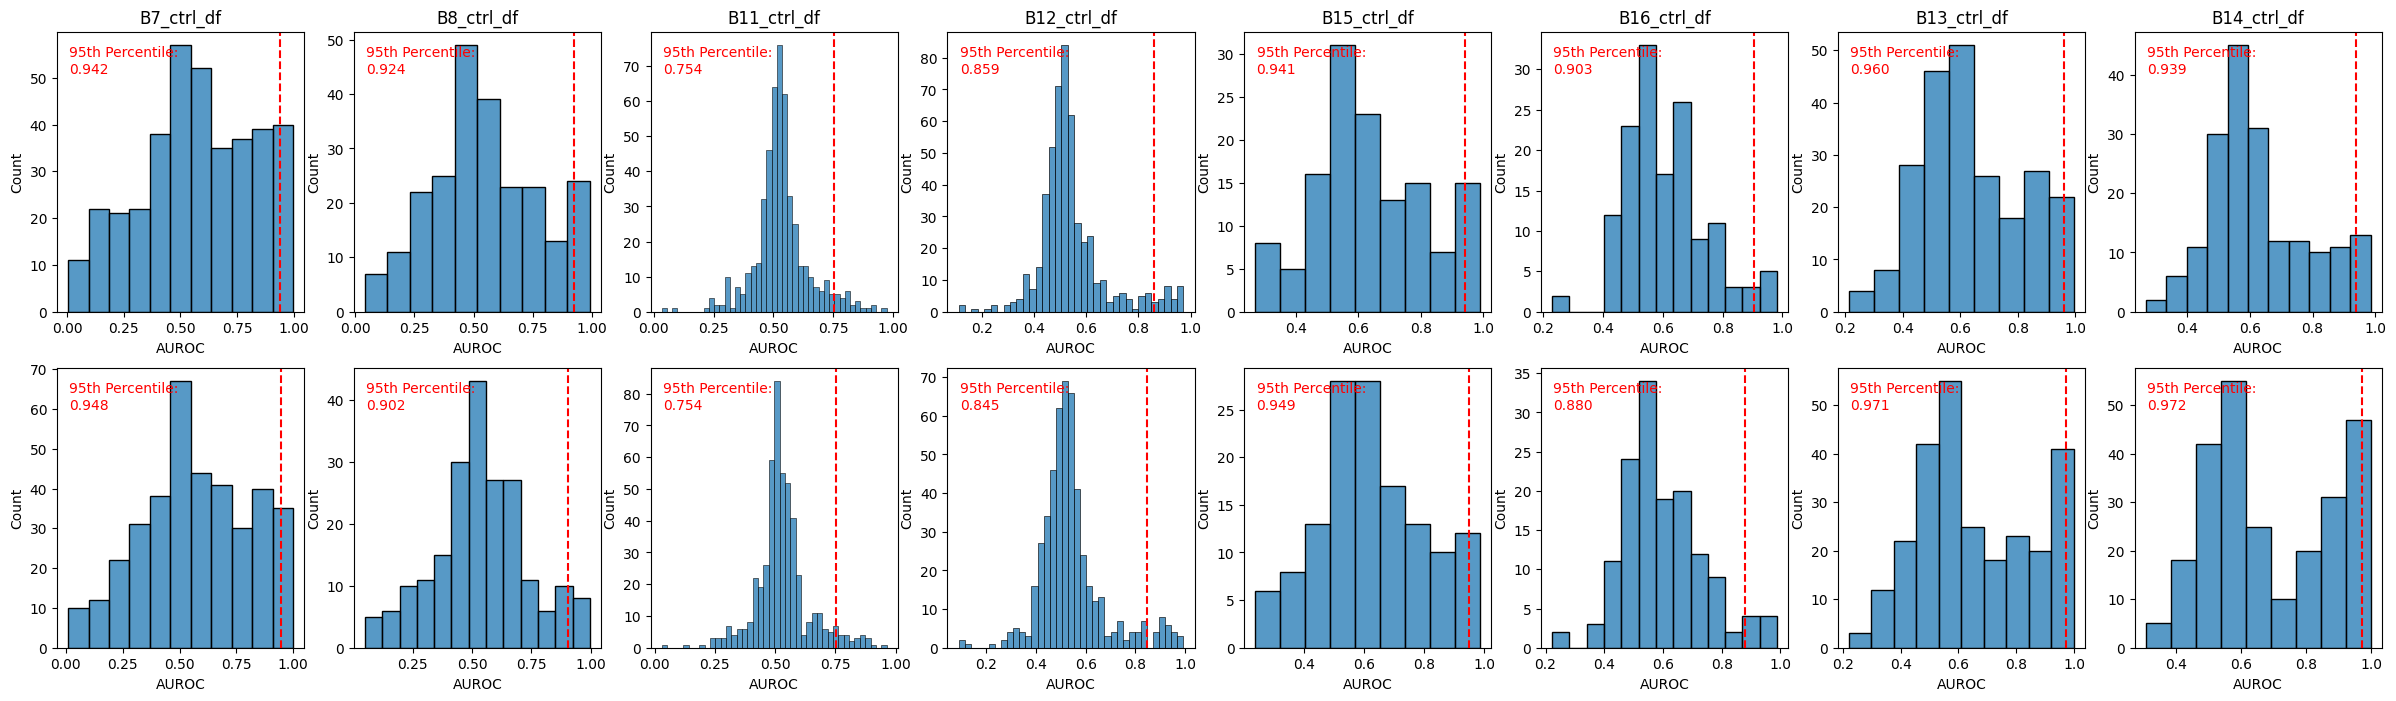

In [7]:
gfp_df_all, gfp_adj_df_all = pl.DataFrame(), pl.DataFrame()
fig, axes = plt.subplots(2, 8, figsize=(30, 8))
i = 0

for key, val in metric_df_dict.items():
    if "ctrl" not in key or "B18" in key or "B19" in key:
        continue

    gfp_df = val.sort(
        "AUROC", descending=True
    ).filter(
        pl.col("Metadata_Feature_Type")=="GFP"
        # pl.col("allele_0")=="PRKACB",
    ).select(
        "AUROC", "well_0", "well_1", "Training_imbalance","allele_0", "Plate", "Metadata_Feature_Type"
    )

    print(gfp_df.select(["AUROC", "Metadata_Feature_Type"])
        .group_by(["Metadata_Feature_Type"])
        .agg([
            pl.col("AUROC").mean().alias("AUROC_ADJ_mean"),
            pl.col("AUROC").std().alias("AUROC_ADJ_std")
        ]+[
            pl.col("AUROC").quantile(auroc_thres).alias(f"AUROC_ADJ_thresh_{auroc_thres*100:.0f}") for auroc_thres in AUROC_THRESHOLDS
        ])
    )
    
    gfp_adj_df = metric_df_ctrl_gfp_adj_dict[key][0].sort(
        "AUROC", descending=True
    ).select(
        "AUROC", "well_0", "well_1", "Training_imbalance","allele_0", "Plate", "well_0_s2n", "well_1_s2n"
    )
    # .filter(
    #     pl.col("well_0_s2n")>=1,
    #     pl.col("well_1_s2n")>=1,
    # )

    gfp_df_all = pl.concat([gfp_df_all, gfp_df])
    gfp_adj_df_all = pl.concat([gfp_adj_df_all, gfp_adj_df])

    # print(val)
    sns.histplot(
        data=gfp_df.to_pandas(),
        x="AUROC",
        ax=axes[0, i]
    )
    axes[0,i].axvline(x=np.percentile(gfp_df["AUROC"], 95), color='red', linestyle='--')
    axes[0,i].text(
        0.05,
        0.95,
        f"95th Percentile:\n{np.percentile(gfp_df['AUROC'], 95):.3f}",
        color="red",
        transform=axes[0, i].transAxes,
        va="top"
    )

    sns.histplot(
        data=gfp_adj_df.to_pandas(),
        x="AUROC",
        ax=axes[1, i]
    )
    axes[1,i].axvline(x=np.percentile(gfp_adj_df["AUROC"], 95), color='red', linestyle='--')
    axes[1,i].text(
        0.05,
        0.95,
        f"95th Percentile:\n{np.percentile(gfp_adj_df['AUROC'], 95):.3f}",
        color="red",
        transform=axes[1, i].transAxes,
        va="top"
    )

    axes[0,i].set_title(key)
    i += 1

print("All", gfp_df_all.shape, np.percentile(gfp_df_all["AUROC"],95))
print("All GFP adjusted", gfp_adj_df_all.shape, np.percentile(gfp_adj_df_all["AUROC"], 95))

In [8]:
df_tmp = metric_df_dict["B8_ctrl_df"].filter(
    pl.col("Metadata_Feature_Type")=="GFP"
    # pl.col("allele_0")=="PRKACB",
)

display(df_tmp.select(
    "AUROC", "well_0", "well_1", "Training_imbalance","allele_0", "Plate", "Metadata_Feature_Type"
).group_by(["Metadata_Feature_Type"]).agg([
    pl.col("AUROC").mean().alias("AUROC_ADJ_mean"),
    pl.col("AUROC").std().alias("AUROC_ADJ_std")
]+[
    pl.col("AUROC").quantile(auroc_thres, interpolation="lower").alias(f"AUROC_ADJ_thresh_{auroc_thres*100:.0f}") for auroc_thres in [0.95]
]))

np.percentile(df_tmp["AUROC"], 95, method="lower")

shape: (1, 4)
┌───────────────────────┬────────────────┬───────────────┬─────────────────────┐
│ Metadata_Feature_Type ┆ AUROC_ADJ_mean ┆ AUROC_ADJ_std ┆ AUROC_ADJ_thresh_95 │
│ ---                   ┆ ---            ┆ ---           ┆ ---                 │
│ str                   ┆ f64            ┆ f64           ┆ f64                 │
╞═══════════════════════╪════════════════╪═══════════════╪═════════════════════╡
│ GFP                   ┆ 0.545707       ┆ 0.22337       ┆ 0.921296            │
└───────────────────────┴────────────────┴───────────────┴─────────────────────┘

0.9212962962962963

No significant difference between the distributions and thresholds. Better stick with the original one to reduce complications.

## 2. Visualize the images

In [11]:
for bio_rep, bio_rep_batches in BIO_REP_BATCHES_DICT.items():
    if bio_rep != "2025_01_Batch_13-14":
        continue
    control_alleles = allele_meta_df_dict[bio_rep].filter(
        (pl.col("node_type")=="PC") | (pl.col("node_type")=="NC")
    ).unique("gene_allele")["gene_allele"]
    for allele in control_alleles:
        # if allele != "ALK_Arg1275Gln":
        #     continue

        control_allele_df_both = pl.DataFrame()
        for batch_id in bio_rep_batches:
            batch_id = f"B{batch_id.split('Batch_')[-1]}"
            # print(metric_df_dict["2025_03_Batch_15-16"].filter(pl.col("gene_allele")==allele))
            # print(wells)
            # break
            control_allele_df = metric_df_dict[f"{batch_id}_ctrl_df"].filter(
                ((pl.col("allele_0")==allele)|(pl.col("allele_1")==allele)),
                (pl.col("Metadata_Feature_Type")=="GFP")&(pl.col("AUROC")>0.90)
            )
            control_allele_df_both = pl.concat([control_allele_df_both, control_allele_df])

        if control_allele_df_both.shape[0] == 0:
            print(bio_rep, allele, "No significant changes")
            continue
        print(bio_rep, allele, "High AUROC:")

        unique_plates = allele_meta_df_dict[bio_rep].filter(
            pl.col("gene_allele")==allele
        ).unique("imaging_plate_R1")["imaging_plate_R1"].to_list()
        for plate in unique_plates:
            plate_allele_df = allele_meta_df_dict[bio_rep].filter(
                pl.col("imaging_plate_R1")==plate,
                pl.col("gene_allele")==allele
            )
            allele_wells = plate_allele_df.unique("well_position").select("well_position").to_series().to_list()
            sig_diff_wells = [well for well in allele_wells if well in \
                control_allele_df_both["well_1"].unique() or well in control_allele_df_both["well_0"].unique()
            ]
            # print(sig_diff_wells)

            plot_allele(plate_allele_df, allele, allele, "GFP", 
                        plate_img_qc=img_well_qc_sum_dict[bio_rep],
                        ref_well=[sig_diff_wells[0]],
                        var_well=[sig_diff_wells[1]],
                        site="05", max_intensity=0.99, display=False, 
                        imgs_dir=TIFF_IMGS_DIR,
                        output_dir="../../2.snakemake_pipeline/outputs/visualize_imgs/control_alleles")
            
            if len(sig_diff_wells) == 3:
                plot_allele(plate_allele_df, allele,  allele, "GFP", 
                            plate_img_qc=img_well_qc_sum_dict[bio_rep],
                            ref_well=[sig_diff_wells[1]],
                            var_well=[sig_diff_wells[2]],
                            site="05", max_intensity=0.99, display=False, 
                            imgs_dir=TIFF_IMGS_DIR,
                            output_dir="../../2.snakemake_pipeline/outputs/visualize_imgs/control_alleles")
            if len(sig_diff_wells) == 4:
                plot_allele(plate_allele_df, allele,  allele, "GFP", 
                            plate_img_qc=img_well_qc_sum_dict[bio_rep],
                            ref_well=[sig_diff_wells[2]],
                            var_well=[sig_diff_wells[3]],
                            site="05", max_intensity=0.99, display=False, 
                            imgs_dir=TIFF_IMGS_DIR,
                            output_dir="../../2.snakemake_pipeline/outputs/visualize_imgs/control_alleles")
    #         break
    #     break
    # break

2025_01_Batch_13-14 PRKACB No significant changes
2025_01_Batch_13-14 ALK High AUROC:


2025_01_Batch_13-14 SLIRP High AUROC:
2025_01_Batch_13-14 ALK_Arg1275Gln High AUROC:
2025_01_Batch_13-14 MAPK9 High AUROC:
2025_01_Batch_13-14 RHEB High AUROC:


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

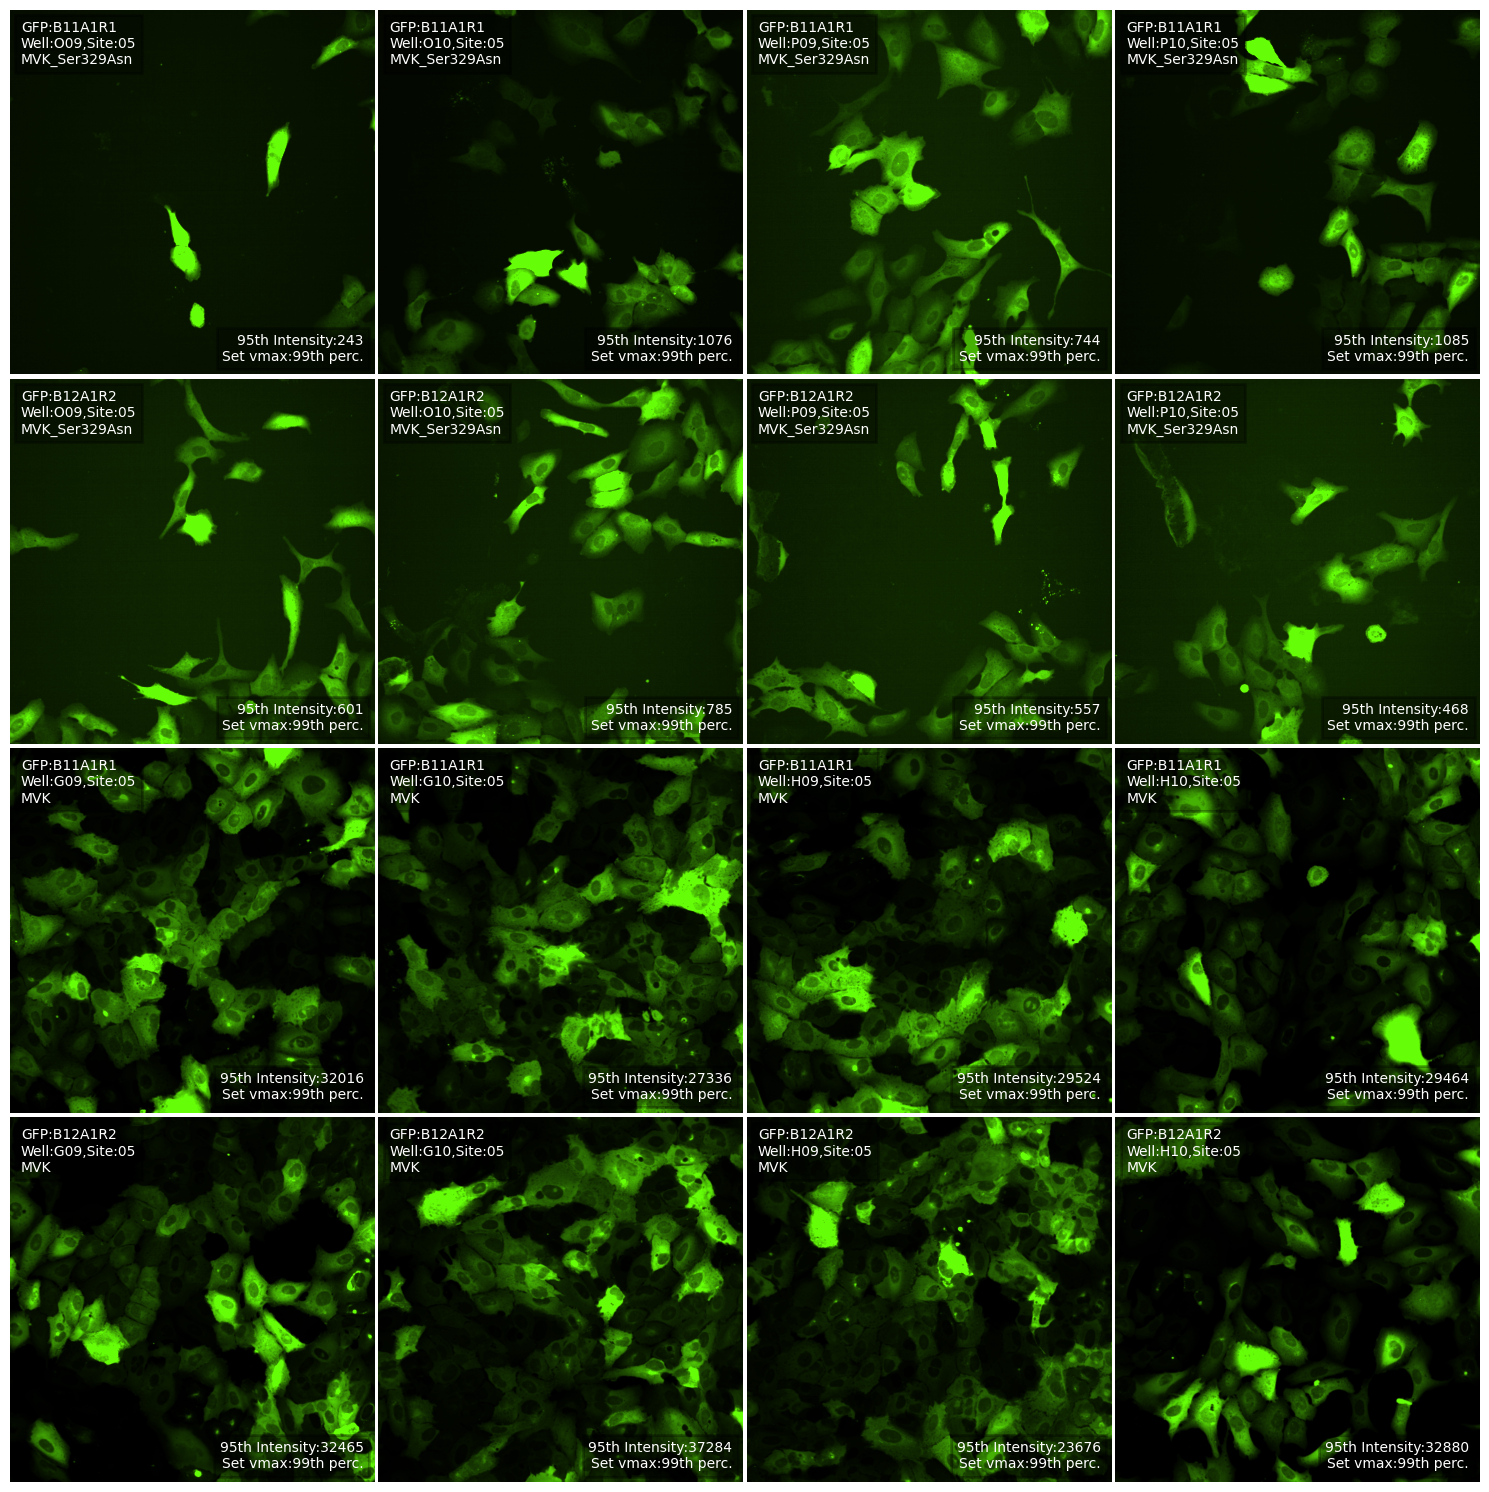

In [14]:
plot_allele_single_plate(allele_meta_df_dict["2024_12_Batch_11-12"], "MVK_Ser329Asn", "GFP", 
            plate_img_qc=img_well_qc_sum_dict["2024_12_Batch_11-12"],
            # ref_well=[sig_diff_wells[2]],
            # var_well=[sig_diff_wells[3]],
            site="05", max_intensity=0.99, 
            display=True, 
            imgs_dir=TIFF_IMGS_DIR,
            output_dir="")

<Figure size 640x480 with 0 Axes>

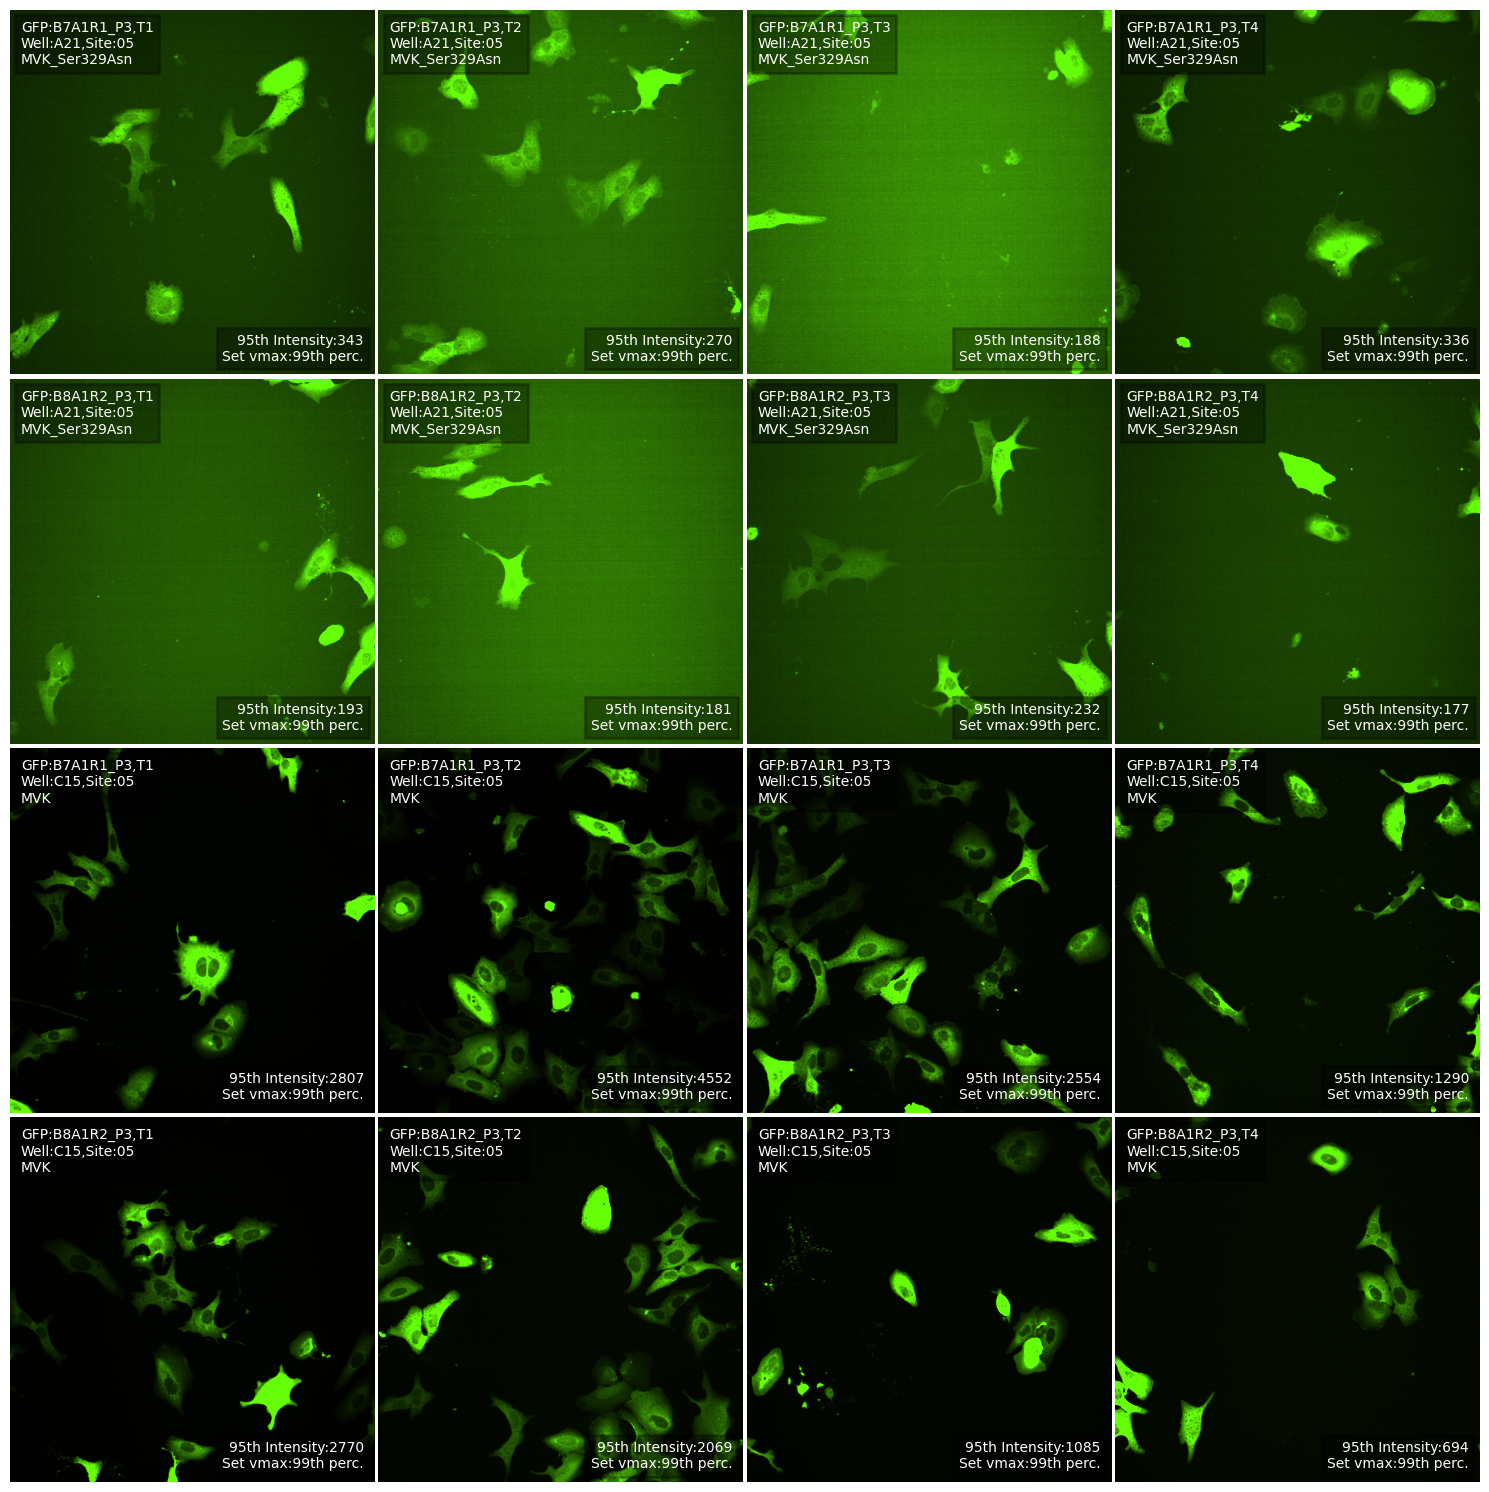

In [ ]:
plot_allele(allele_meta_df_dict["2024_01_Batch_7-8"], "MVK",  "MVK_Ser329Asn", "GFP", 
            plate_img_qc=img_well_qc_sum_dict["2024_01_Batch_7-8"],
            # ref_well=[sig_diff_wells[2]],
            # var_well=[sig_diff_wells[3]],
            site="05", max_intensity=0.99, 
            display=True, 
            imgs_dir=TIFF_IMGS_DIR,
            output_dir="")